In [1]:
pip install mne

Note: you may need to restart the kernel to use updated packages.


## Project Aim
To sum up, our project is aiming to provide a practical and low cost solution for the complications that might be found in the real world’s engineering diesel engine laboratories through providing a virtual model that is characterized by the reality of the diesel engine lab, ease of use using only VR headset and input gloves and also provides additional features that would help students achieve maximum output through immersion with the machine and visualize everything that’s happening inside it.
## Project objectives
In order to achieve the project aim, we need to divide our project into three main objectives. First, we have to study the diesel engine lab in details and learn how to design a 3D simulation for the engine. After building the 3D model, the next step is to bring this model into a virtual world in which the student will be able to interact with our model. Now we have the VR world with our model inside. The next step is providing the hardware to be used to ensure the full immersion of the student with the virtual lab. We have decided to use human activity recognition input as a way of convincing the student’s mind? that everything around him is a reality rather than a virtual one to ensure full engagement. Finally, we need to work on the integration of all these parts to provide the best immersive learning experience.
## The Brain Computer Interface
Model evaluation is an essential phase in building engineering systems to ensure the quality and efficiency of the system. The proposed model is meant to replace the traditional mechanical labs that contain heave machines with a virtual-based technology that is assumed to be helpful in student’s understanding and interaction with machines. The challenge was how to evaluate the system so that student’s understanding can be indicated. After a lot of research, it’s found that a brain-computer interface (BCI) is the most suitable way to achieve that since it is widely used in applications similar to the one our team was working on.

BCI is a system that uses electrodes to establish direct communication between the brain and an external device such computer or robotic arm. There are two ways to establish a BCI system the invasive and non-invasive. The invasive requires a surgical operation to insert the electrodes under the patient’s skin. On the other hand, the non-invasive does not require that it is implemented by placing the electrodes on one’s scalp. Electroencephalography (EEG) is the most well-known technique in building a non-invasive BCI system that captures the brain's electrical activity. The simplicity of use, mobility, lower cost, and high temporal resolution are the main reasons for EEG popularity and what motivated the team to use it. There are other alternatives, but they are not as efficient as the EEG.

BCI is used in many useful applications such as stress detection, motor imagery tasks, and spinal cord rehabilitation. A typical BCI is used to retrieve data from the brain and send them to an external device to perform a certain task. In the proposed system BCI using EEG is only used to extract the signals and classify them to get specific information.
For More information and details about the proposed system, you can read the project thesis from [here](https://drive.google.com/file/d/1TIZG_nHjvSIpkaF6ljJbaHdDGIdiOCbI/view?usp=sharing)

### Importing Packages 

In [2]:
import mne
# Importing numpy 
import numpy as np
# Importing Scipy 
import scipy as sp
# Importing Pandas Library 
import pandas as pd
# import glob function to scrap files path
from glob import glob
# import display() for better visualitions of DataFrames and arrays
from IPython.display import display
# import pyplot for plotting
import matplotlib.pyplot as plt
import math
from skimage.restoration import denoise_wavelet
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import seaborn as sns
import pywt

,RAW
0,129
1,-89
2,-379
3,-408
4,-124


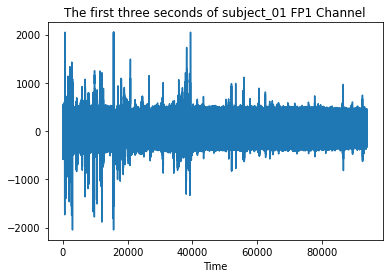

In [3]:
d_frame=pd.read_csv('../input/eeg-dataset-collected-from-students-using-vr/EEG_Dataset/Subject00_0.csv')        
d_frame.drop(columns='TimeDate',inplace=True)          # converting the raw file to data frame
plt.plot(d_frame['RAW'][0:])           # visualizing the first 10000 values of channel ECG ECG 
plt.xlabel('Time')
plt.title('The first three seconds of subject_01 FP1 Channel')
d_frame.head()


Text(0.5, 1.0, 'The Distribution of the EEG FP1 ')

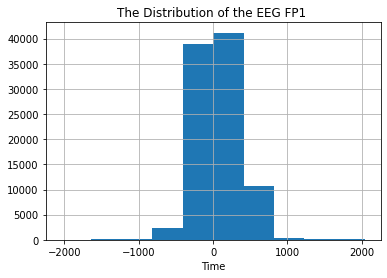

In [4]:
d_frame['RAW'].hist()
plt.xlabel('Time')
plt.title('The Distribution of the EEG FP1 ')

In [5]:
Raw_data_paths = sorted(glob("../input/eeg-dataset-collected-from-students-using-vr/EEG_Dataset/*"))

In [6]:
len(Raw_data_paths)

6

In [7]:
Raw_data_paths

['../input/eeg-dataset-collected-from-students-using-vr/EEG_Dataset/Readme.txt',
 '../input/eeg-dataset-collected-from-students-using-vr/EEG_Dataset/Subject00_0.csv',
 '../input/eeg-dataset-collected-from-students-using-vr/EEG_Dataset/Subject01_1.csv',
 '../input/eeg-dataset-collected-from-students-using-vr/EEG_Dataset/Subject02_0.csv',
 '../input/eeg-dataset-collected-from-students-using-vr/EEG_Dataset/Subject03_1.csv',
 '../input/eeg-dataset-collected-from-students-using-vr/EEG_Dataset/Subject04_0.csv']

In [8]:
def create_student_data_dict(Raw_data_paths):
    """
    This function creates a dictionary that contains students as keys 
    and the eeg data as values.
    INPUT -----> the sorted list of student' EEG files.
    OUTPUT ----> A python Dict that contains 
    keys: Students 
    Values: Data
    """
    raw_dic={}                                   
    for path_index in range(1,6):
        key= Raw_data_paths[path_index][-15:-4]     # to extract the subjectxx-x from the files
        data_frame=pd.read_csv(Raw_data_paths[path_index])
        data_frame.drop(columns='TimeDate',inplace=True) 
        raw_dic[key]=data_frame
    return raw_dic
raw_dic=create_student_data_dict(Raw_data_paths)

In [9]:
# raw_dic is a dictionary contains 61 DF
print('raw_dic contains %d DataFrame' % len(raw_dic))

# print the first 3 rows of dataframe exp01_user01
raw_dic['Subject00_0']

raw_dic contains 5 DataFrame


,RAW
0,129
1,-89
2,-379
3,-408
4,-124
...,...
94130,18
94131,-246
94132,-169
94133,76


In [10]:
number_of_channels= raw_dic['Subject00_0'].shape[1]
number_of_channels

1

In [11]:
names_of_channels=raw_dic['Subject01_1'].columns
names_of_channels

Index(['RAW'], dtype='object')

## Signal Processing 
The signal processing methods applied in the proposed system are the same as the authors in this [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7278014/) used. The filters are defined using the [Scipy package](https://www.scipy.org/) to remove artifacts.

The filters used are third-order:
* `median filter`
* `low pass filter`
* `high pass filter`
* `notch filter`

For denoising and smoothing:

* `wavelet denoising`
* `Savitzky–Golay filter`

First, the raw signals were filtered using the third-order median filter to remove the background noise. Then, the filtered signals were further filtered using low-pass and high-pass filters. A Butterworth filter with order 5 was used to design these filters at cutoff frequencies of 0.5 HZ and 50 HZ for the low and high filters respectively. The Butterworth filter is a signal processing filter with a frequency response in the passband that is as flat as possible.

Subsequently, a notch filter was applied to reject power interference at 60 HZ. Furthermore, the signals were denoised using a de-noising method based on multilevel wavelet decomposition. The number of wavelet levels was 5, the mother wavelet was Symlets. Lastly, the signals were smoothed using the Savitzky–Golay filter.

In [12]:
#band pass filter between 0.5 and 40 hz
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [13]:
from scipy.signal import medfilt # import the median filter function
def median(signal):# input: numpy array 1D (one column)
    array=np.array(signal)   
    #applying the median filter
    med_filtered=sp.signal.medfilt(array, kernel_size=3) # applying the median filter order3(kernel_size=3)
    return  med_filtered # return the med-filtered signal: numpy array 1D

In [14]:
#notch filter apllied at 50hz
def Implement_Notch_Filter(time, band, freq, ripple, order, filter_type, data):
    from scipy.signal import iirfilter
    fs   = 1/time
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data

In [15]:
def SignalProcessing(raw_dic):
    
    """
    This function impelments the signal processing pipeline through
    1- Median Filter 
    2-band pass filter 
    3-wavelet_denoise
    4-savgol_filter
    INPUT -------> the raw signals
    OUTPUT ------> A dictionary that contains the denoised signals 
    """
    time_sig_dic={} # An empty dictionary will contains dataframes of all time domain signals
    raw_dic_keys=sorted(raw_dic.keys()) # sorting dataframes' keys
    for key in raw_dic_keys:
        
        raw_df=raw_dic[key]
        time_sig_df=pd.DataFrame()
        for column in raw_df.columns:
            
            t_signal=np.array(raw_df[column]) # copie the signal values in 1D numpy array
            med_filtred=median(t_signal) # apply 3rd order median filter and store the filtred signal in med_filtred
            fs = 50
            lowcut = 0.05
            highcut = 5
            band_pass=butter_bandpass_filter(med_filtred, lowcut, highcut, fs, order=5)
            #notch=Implement_Notch_Filter(0.02, 1, 50, 1, 2, 'butter',band_pass)
            wavelet_denoise=denoise_wavelet(band_pass,method='BayesShrink',mode='hard',wavelet='sym9',wavelet_levels=5,rescale_sigma=True)
            clean_signals=savgol_filter(wavelet_denoise, 1111, 3,mode='wrap')
            time_sig_df[column]=clean_signals
            time_sig_dic[key]=time_sig_df
    return time_sig_dic

In [16]:
time_sig_dic=SignalProcessing(raw_dic)

In [17]:
########################################################################################
# Here I wanted to generate a df for the time length                                        
########################################################################################
time_list=[]
for i in range (1,6):
    time=(time_sig_dic[Raw_data_paths[i][-15:-4]].index.values[-1])
    time_list.append(time)
data=np.array(time_list)
time_length=pd.DataFrame(data=data,columns=['Signl length'])
time_length

,Signl length
0,94134
1,98644
2,97153
3,98767
4,98543


In [18]:
# example: 679 ==> '00679'; 50 ==> '00050'

# it add '0's to the left of the input until the new lenght is equal to 5
def normalize5(number): 
    stre=str(number)
    if len(stre)<5:
        l=len(stre)
        for i in range(0,5-l):
            stre="0"+stre
    return stre 

# it add '0's to the left of the input until the new lenght is equal to 2
def normalize2(number):
    stre=str(number)
    if len(stre)<2:
        stre="0"+stre
    return stre

## Windowing 

After filtering the signals, the clean signals were segmented using a sliding window. The process involved some steps. First, a 4-second width window was used to loop through the time-domain signal dividing it into small segments for 4 seconds each. The window width was decided based on the literature done. To decide whether the sliding window has to be overlapping or non-overlapping, both methods were tried. The result was that the overlapping method was more efficient and resulted in higher accuracy. We started with a 50% overlap.

Then, we tried different values until the highest accuracy was achieved at a 4-second sliding window and 3-second overlap. The segments after that were converted from the time-domain to the frequency-domain using the Fast Fourier transform. In addition to that, the signals were obtained in the time-frequency domain as stated in the features extracted in the time-frequency domain result in getting a higher classification accuracy. The Wavelet transformation was used in converting the signals to the time-frequency domain.

In [19]:
def Windowing(time_sig_dic):
    
    
    """
    This Function is used to segment the data to small windows through 
    looping over each dataframe's index and store each 4 secs of the data 
    in a single window with a key that has this pattern
    the window size is calculated as follows:
    wind_size=(1/Fs)*required_window_time_length
    'Subject' + normalize2(int(subject_id))  +  '_' + str(state)
    INPUT ----> The denoised signal dictionary 
    OUTPUT ---> A dictionary that contains the windows 
    """
    window_dict={} 
    columns=time_sig_dic['Subject02_0'].columns
    
    for subject_id , state in zip([0,1,2,3,4],[0,1,0,1,0]):
        
        
    
        file_key= 'Subject' + normalize2(int(subject_id))  +  '_' + str(state)
        dic_update=raw_dic[file_key]
        for sig_time in range(0,len(time_length)):
            
            
            
            sig_time_length=(time_length['Signl length'][sig_time])
            window_ID=0
            for cursor in range(0,(sig_time_length-199),50):
                end_point=cursor+200
                data=np.array(dic_update.iloc[cursor:end_point])
                window=pd.DataFrame(data=data,columns=columns)
                key='t_W'+normalize5(window_ID)+'_'+file_key
                window_dict[key]=window
                wind_dic=window_dict[key]
                window_ID=window_ID+1
    return window_dict

In [20]:
window_dict=Windowing(time_sig_dic)

In [21]:
new_frames = {k:v for (k,v) in window_dict.items() if not v.empty}

In [22]:
len(new_frames)

9742

In [23]:
sorted(new_frames.keys())[0]

't_W00000_Subject00_0'

### Fourier Transform  

In [24]:
#Fourier transform function 
from scipy import fftpack # import fftpack to use all fft functions
from numpy.fft import *
##################### fast_fourier_transform_one_signal #################
# Inputs: time signal 1D array
# Output: amplitude of fft components 1D array having the same lenght as the Input
def fast_fourier_transform_one_signal(t_signal):
    # apply fast fourrier transform to the t_signal
    complex_f_signal= fftpack.fft(t_signal)
    #compute the amplitude each complex number
    amplitude_f_signal=np.abs(complex_f_signal)
    # return the amplitude
    return amplitude_f_signal
##################### fast fourier transform for data frames #################
def fast_fourier_transform(t_window):
  f_window=pd.DataFrame() # create an empty dataframe will include frequency domain signals of window
  for column in t_window.columns: 
    t_signal=np.array(t_window[column]) # convert the column to a 1D numpy array
    f_signal= np.apply_along_axis(fast_fourier_transform_one_signal,0,t_signal) # apply the function defined above to the column
    f_window["freq_"+column[0:]]=f_signal # storing the frequency signal in f_window with an appropriate column name
  return f_window # return the frequency domain window

In [25]:
f_window_dict = {'f'+key[1:] : t_w1_df.pipe(fast_fourier_transform) for key, t_w1_df in new_frames.items()}

In [26]:
fnew_frames = {k:v for (k,v) in f_window_dict.items() if not v.empty}

In [27]:
len(fnew_frames)

9742


## Wavelet Transform 

In [28]:
def tf(t_freq_signal):
    
    """
    This Function is to obtian the signals in the time-frequency domian.
    
    """
    (cA, cD) = pywt.dwt(t_freq_signal, 'db1')
    x=np.concatenate((cD,cA),axis=0)
    return x

In [29]:
time_freq_dic={}
time_dic_keys=sorted(new_frames.keys())
for k in time_dic_keys:
  time_df=new_frames[k]
  time_freq_df=pd.DataFrame()
  for c in time_df.columns:
    t_freq_signal=np.array(time_df[c])
    sum_of_coff=np.apply_along_axis(tf,0,t_freq_signal)
    time_freq_df['time_freq'+c]=sum_of_coff
    time_freq_dic[k]=time_freq_df

In [30]:
time_freq_dic['t_W00000_Subject00_0']
time_freq_dic['t_W00000_Subject00_0'].columns[0]

'time_freqRAW'

In [31]:
t_f_newframes = {k:v for (k,v) in time_freq_dic.items() if not v.empty}

In [32]:
t_f_newframes['t_W00000_Subject00_0']

,time_freqRAW
0,154.149278
1,20.506097
2,-282.842712
3,61.518290
4,67.175144
...,...
195,233.345238
196,614.475793
197,193.747258
198,-268.700577


 ## Feature Extraction
The features extracted from each column in time, frequency, and time-frequency domains were: The mean x̄ of a data set is the sum of all the data divided by the count n.

                   (Sum of terms)/(number of terms )
The standard deviation is a statistic that measures the amount of variation or dispersion in a set of numbers. A low standard deviation implies that the values are close to the set's mean, whereas a high standard deviation shows that the values are dispersed across a larger range.

                          σ= √∑(X_(i )-μ)/N
σ = population standard deviation
N = the size of the population
X_(i ) = each value from the population
μ = the population mean
In statistics, the median absolute deviation is a robust measure of the variability of a univariate sample of quantitative data. It can also refer to the population parameter that is estimated by the MAD calculated from a sample.

                  median absolute deviation=|X_(i )-mean|
X_i = each value

In descriptive statistics, the interquartile range, also called the midspread, middle 50%, or H‑spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles. In information theory, the entropy of a random variable is the average level of "information", "surprise", or "uncertainty" inherent in the variable's possible outcomes. In addition to the minimum and maximum value in each column. The entropy, energy, skewness, and kurtosis features that work well in classifying EEG data were also extracted from the data in the three domains.

In [33]:
# df is dataframe contains 3 columns (3 axial signals X,Y,Z)

# mean
def mean_axial(df):
    array=np.array(df) # convert dataframe into 2D numpy array for efficiency
    mean_vector = array.mean(axis=0) # calculate the mean value of each column
    return mean_vector # return mean vetor
# std
def std_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    std_vector =array.std(axis=0)# calculate the standard deviation value of each column
                     
    return std_vector

# mad
from statsmodels.robust import mad as median_deviation # import the median deviation function
def mad_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    mad_vector = median_deviation(array,axis=0) # calculate the median deviation value of each column
    return mad_vector

# max

def max_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    max_vector=array.max(axis=0)# calculate the max value of each column
    return max_vector
# min
def min_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    min_vector=array.min(axis=0)# calculate the min value of each column
    return min_vector
# IQR
from scipy.stats import iqr as IQR # import interquartile range function (Q3(column)-Q1(column))
def IQR_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    IQR_vector=np.apply_along_axis(IQR,0,array)# calculate the inter quartile range value of each column
    return IQR_vector


# Entropy
from scipy.stats import entropy # import the entropy function
def entropy_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    entropy_vector=np.apply_along_axis(entropy,0,abs(array))# calculate the entropy value of each column
    return entropy_vector

In [34]:
pip install spectrum

     |████████████████████████████████| 228 kB 825 kB/s 
  Created wheel for spectrum: filename=spectrum-0.8.0-cp37-cp37m-linux_x86_64.whl size=235814 sha256=caf85291e56c207daafe31bbb5d1e868d89b26623302208ce5bee067b8606115
  Stored in directory: /root/.cache/pip/wheels/ac/a0/2b/aba9ac3cce046bc454a44d0db5b711b4e927a0dd33a93e9d98
Successfully built spectrum
Note: you may need to restart the kernel to use updated packages.


In [35]:
# energy
def t_energy_axial(df):
    array=np.array(df)
    energy_vector=(array**2).sum(axis=0) # energy value of each df column
    return energy_vector # return energy vector energy_X,energy_Y,energy_Z

In [36]:
#Time Features PipeLine
def t_axial_features_generation(t_window):
  axial_columns=t_window.columns[0]
  axial_df=t_window[axial_columns]
  t_axial_features=[]
  df=axial_df  
  mean_vector   = list(mean_axial(t_window)) 
  std_vector    = list(std_axial(t_window)) 
  mad_vector    = list(mad_axial(t_window))
  max_vector    = list(max_axial(t_window))
  min_vector    = list(min_axial(t_window))
  energy_vector = list(t_energy_axial(t_window))
  IQR_vector    = list(IQR_axial(t_window))
  entropy_vector= list(entropy_axial(t_window))
  # 40 value per each 3-axial signals
  t_3axial_vector= mean_vector + std_vector + mad_vector + max_vector + min_vector + energy_vector + IQR_vector + entropy_vector 
  t_axial_features= t_axial_features+ t_3axial_vector
  return t_axial_features

In [37]:
def time_features_names():
    # Generating time feature names
    t_axis_signals=[['EEG '],]
    # functions' names:
    t_one_input_features_name1=['_mean()','_std()','_mad()','_max()','_min()']
    t_one_input_features_name2=['_energy()','_iqr()','_entropy()']
    features=[]# Empty list : it will contain all time domain features' names
    for columns in t_axis_signals: # iterate throw  each group of 3-channels'        
        for feature in t_one_input_features_name1: # iterate throw the first list of functions names            
            for column in columns: # iterate throw each axial signal in that group              
                newcolumn=column+feature # build the feature name
                features.append(newcolumn) # add it to the global list
        for feature in t_one_input_features_name2: # same process for the second list of features functions
            for column in columns:
                newcolumn=column+feature
                features.append(newcolumn)         
    ###########################################################################################################
    time_list_features=features
    
    return time_list_features # return all time domain features' names

In [38]:
#Frequency Features 
def f_energy_axial(df):
    
    array=np.array(df)
    
    # spectral energy vector
    energy_vector=(array**2).sum(axis=0)/float(len(array))
    
    return energy_vector 
########## Skewness & Kurtosis Functions #######################################
from scipy.stats import kurtosis       # kurtosis function
from scipy.stats import skew           # skewness function
    
def f_skewness_and_kurtosis_axial(df):
    array=np.array(df)
    
    skew_X= skew(array)  
    kur_X= kurtosis(array)  
    
    #skew_Y= skew(array[:,1]) 
    #kur_Y= kurtosis(array[:,1])
    
    #skew_Z= skew(array[:,2])
    #kur_Z= kurtosis(array[:,2])
    
    skew_kur_3axial_vector=[skew_X,kur_X]  #,skew_Y,kur_Y,skew_Z,kur_Z] 
    
    return skew_kur_3axial_vector

In [39]:
#Time_freq features
def t_f_skewness_and_kurtosis_axial(df):
    array=np.array(df)
    
    skew_X= skew(array)  
    kur_X= kurtosis(array)  
    
    #skew_Y= skew(array[:,1]) 
    #kur_Y= kurtosis(array[:,1])
    
    #skew_Z= skew(array[:,2])
    #kur_Z= kurtosis(array[:,2])
    
    skew_kur_3axial_vector=[skew_X,kur_X]#,skew_Y,kur_Y,skew_Z,kur_Z] 
    
    return skew_kur_3axial_vector


In [40]:
def f_axial_features_generation(f_window):


  axial_columns=f_window.columns[0]
  axial_df=f_window[axial_columns] 
  f_all_axial_features=[] 
  df=axial_df     
  mean_vector   = list(mean_axial(f_window)) # 3values
  std_vector    = list(std_axial(f_window)) # 3 values
  mad_vector    = list(mad_axial(f_window))# 3 values
  max_vector    = list(max_axial(f_window))# 3 values
  min_vector    = list(min_axial(f_window))# 3 values
  IQR_vector    = list(IQR_axial(f_window))# 3 values
  entropy_vector= list(entropy_axial(f_window))# 3 values
  energy_vector                = list(f_energy_axial(f_window))
  skewness_and_kurtosis_vector = f_skewness_and_kurtosis_axial(f_window)# 6 values
  f_3axial_features =  mean_vector +std_vector + mad_vector+max_vector+min_vector+  energy_vector + IQR_vector + entropy_vector +  skewness_and_kurtosis_vector  
  f_all_axial_features = f_all_axial_features+ f_3axial_features # add features to the global list
  return f_all_axial_features

In [41]:
def t_f_axial_features_generation(t_f_window):
  axial_columns=t_f_window.columns[0]
  axial_df=t_f_window[axial_columns] 
  t_f_all_axial_features=[] 
  df=axial_df    
  mean_vector   = list(mean_axial(t_f_window)) # 3values
  std_vector    = list(std_axial(t_f_window)) # 3 values
  mad_vector    = list(mad_axial(t_f_window))# 3 values
  max_vector    = list(max_axial(t_f_window))# 3 values
  min_vector    = list(min_axial(t_f_window))# 3 values
  IQR_vector    = list(IQR_axial(t_f_window))# 3 values
  entropy_vector= list(entropy_axial(t_f_window))# 3 values
  #energy_vector                = f_energy_axial(df)
  skewness_and_kurtosis_vector = t_f_skewness_and_kurtosis_axial(t_f_window)# 6 values
  f_3axial_features =  mean_vector +std_vector + mad_vector+max_vector+min_vector+  IQR_vector + entropy_vector +  skewness_and_kurtosis_vector  
  t_f_all_axial_features = t_f_all_axial_features+ f_3axial_features # add features to the global list
  return t_f_all_axial_features

In [42]:
def frequency_features_names():
    axial_signals=[['EEG ']]
    # features functions names will be applied to f_signals
    f_one_input_features_name1=['_mean()','_std()','_mad()','_max()','_min()']
    f_one_input_features_name2=['_energy()','_iqr()','_entropy()']
    f_one_input_features_name3= ['_skewness()','_kurtosis()']    
    frequency_features_names=[] # global list of frequency features
    for columns in axial_signals: # iterate throw each group of 3-axial signals
        # iterate throw the first list of features
        for feature in f_one_input_features_name1: 
            for column in columns:# iterate throw each signal name of that group
                newcolumn=column+feature # build the full feature name
                frequency_features_names.append(newcolumn) # add the feature name to the global list
        # iterate throw the first list of features
        for feature in f_one_input_features_name2:
            for column in columns:
                newcolumn=column+feature
                frequency_features_names.append(newcolumn)
        # iterate throw each signal name of that group
        for column in columns:
            for feature in f_one_input_features_name3: # iterate throw [skewness ,kurtosis]
                newcolumn=column+feature # build full feature name
                frequency_features_names.append(newcolumn) # append full feature names#
    return frequency_features_names

In [43]:
def t_frequency_features_names():
    axial_signals=[['EEG ']]
    # features functions names will be applied to f_signals
    f_one_input_features_name1=['_mean()','_std()','_mad()','_max()','_min()']
    f_one_input_features_name2=['_iqr()','_entropy()']
    f_one_input_features_name3= ['_skewness()','_kurtosis()']    
    time_frequency_features_names=[] # global list of frequency features
    for columns in axial_signals: # iterate throw each group of 3-axial signals
        # iterate throw the first list of features
        for feature in f_one_input_features_name1: 
            for column in columns:# iterate throw each signal name of that group
                newcolumn=column+feature # build the full feature name
                time_frequency_features_names.append(newcolumn) # add the feature name to the global list
        # iterate throw the first list of features
        for feature in f_one_input_features_name2:
            for column in columns:
                newcolumn=column+feature
                time_frequency_features_names.append(newcolumn)
        # iterate throw each signal name of that group
        for column in columns:
            for feature in f_one_input_features_name3: # iterate throw [skewness ,kurtosis]
                newcolumn=column+feature # build full feature name
                time_frequency_features_names.append(newcolumn) # append full feature names#
    return time_frequency_features_names

In [44]:
# conctenate all features names lists and we add two other columns state and subject will be related to each row
all_columns=time_features_names()+frequency_features_names()+t_frequency_features_names()+['state','subject']
def Dataset_Generation_PipeLine(t_dic,f_dic,t_f_dic):
    # t_dic is a dic contains time domain windows
    final_Dataset=pd.DataFrame(data=[],columns= all_columns) # build an empty dataframe to append rows
    for i in range(len(t_dic)): # iterate throw each window
        # t_window and f_window should have the same window id included in their keys
        t_key=sorted(t_dic.keys() )[i] # extract the key of t_window 
        f_key=sorted(f_dic.keys() )[i] # extract the key of f_window
        t_f_key=sorted(t_f_dic.keys() )[i]
        t_window=t_dic[t_key] # extract the t_window
        f_window=f_dic[f_key] # extract the f_window
        t_f_window=t_f_dic[t_f_key]

        window_user_id= int(t_key[-4:-2]) # extract the user id from window's key
        window_activity_id=int(t_key[-1]) # extract the activity id from the windows key
        # generate all time features from t_window 
        time_features = t_axial_features_generation(t_window) 
        frequency_features = f_axial_features_generation(f_window)
        time_freq_features=t_f_axial_features_generation(t_f_window)
        # concatenate all features and append the activity id and the user id
        row= time_features +frequency_features+time_freq_features+ [int(window_activity_id),int(window_user_id)]
        # go to the first free index in the dataframe
        free_index=len(final_Dataset)
        # append the row
        final_Dataset.loc[free_index]= row  
    return final_Dataset # return the final dataset

In [45]:
Dataset= Dataset_Generation_PipeLine(new_frames,fnew_frames,t_f_newframes)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [46]:
print('The shape of Dataset is :',Dataset.shape) # shape of the dataset 
display(Dataset.describe()) # statistical description
display(Dataset.head(10)) # the first three rows

The shape of Dataset is : (9742, 29)


,EEG _mean(),EEG _std(),EEG _mad(),EEG _iqr(),EEG _entropy(),EEG _mean(),EEG _std(),EEG _mad(),EEG _max(),EEG _min(),EEG _energy(),EEG _iqr(),EEG _entropy(),EEG _mean(),EEG _std(),EEG _mad(),EEG _max(),EEG _min(),EEG _iqr(),EEG _entropy()
count,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9.742000e+03,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000
mean,49.241710,295.587689,343.231317,526.397018,5.116119,1760.970647,3932.927117,443.320742,31075.504015,110.657421,2.398388e+07,1263.131422,4.283873,34.813053,300.699405,267.735395,674.846468,-647.880528,360.870425,4.930832
std,38.223876,169.460790,192.227469,313.853300,0.075125,945.188146,2126.527087,253.114241,15713.431045,132.062612,2.247790e+07,663.822093,0.161942,27.057895,166.164376,162.535599,329.341130,405.786094,210.348426,0.132325
min,-384.815000,18.220867,20.756431,27.250000,1.382603,227.336213,336.302670,32.042736,848.000000,0.000000,1.757440e+05,88.801650,0.461368,-273.070497,29.423901,16.773729,33.941125,-2896.309376,22.273864,0.736067
25%,41.880000,192.234805,234.251151,351.250000,5.088626,1151.805410,2565.401461,220.332282,19264.033253,18.969379,7.936293e+06,821.234226,4.193544,29.410339,195.939657,169.309830,474.645427,-952.296058,231.931024,4.931767
50%,49.390000,267.748566,344.705016,470.750000,5.135806,1704.452661,3490.082241,456.662347,30200.740009,57.615504,1.490363e+07,1243.695925,4.303921,34.938146,270.624859,241.646538,659.023520,-545.886435,296.631295,4.985553
75%,56.678750,436.757096,513.721669,790.000000,5.156964,2534.339893,5691.912332,620.080933,42721.707708,152.722280,3.885157e+07,1723.967530,4.390913,40.262660,438.834741,397.327713,914.996175,-417.193001,548.007755,5.003716
max,630.265000,1289.697303,1667.186195,2399.250000,5.253676,6231.930604,17346.809698,1650.271519,151308.660491,952.794316,3.363288e+08,3883.131714,4.812922,445.236856,1293.332000,757.438715,2894.895162,-5.656854,1005.152289,5.080047


,EEG _mean(),EEG _std(),EEG _mad(),EEG _max(),EEG _min(),EEG _energy(),EEG _iqr(),EEG _entropy(),EEG _mean(),EEG _std(),...,EEG _std(),EEG _mad(),EEG _max(),EEG _min(),EEG _iqr(),EEG _entropy(),EEG _skewness(),EEG _kurtosis(),state,subject
0,52.430,258.690733,330.620295,556,-587,13933960,438.00,5.075521,2165.547123,3040.454844,...,261.268170,253.702656,657.609307,-781.352993,268.700577,4.978994,[0.23563205449993696],[0.2567534212600533],0,0
1,61.125,552.757053,661.981891,950,-982,61855325,940.00,5.118838,3342.727579,7119.093856,...,554.300509,495.873373,1155.412480,-1288.348555,654.604103,5.004412,[-0.09053293193368092],[-0.2438310636097314],1,1
2,42.820,254.083781,303.192154,451,-475,13278424,468.50,5.150551,1821.133173,3156.247450,...,256.271441,229.590420,607.404725,-531.744299,312.364421,4.990480,[0.04465196580456052],[-0.45158065412989945],0,2
3,36.405,55.646572,58.562788,212,-135,884373,76.25,5.015599,537.079691,771.957515,...,61.646015,31.974922,275.771645,-140.007143,67.528698,4.749479,[0.763601574461734],[1.458633910614151],1,3
4,39.090,328.835281,372.874458,504,-643,21932134,595.00,5.168024,1841.607707,4305.881449,...,330.086042,322.370110,685.186471,-831.557575,428.329933,4.965934,[-0.25973713527909137],[-0.30126908954078324],0,4
5,87.425,235.291531,312.087767,556,-296,12601047,430.75,5.070777,1308.423552,3299.859817,...,243.286820,231.687136,671.751442,-393.151370,266.756033,4.971693,[0.6542085813972576],[-0.11935998060420339],0,0
6,55.950,562.119674,678.290515,887,-982,63821786,974.75,5.122006,3101.931665,7362.051748,...,563.571058,495.349194,1178.039897,-1288.348555,676.170860,5.018999,[-0.1054533654730595],[-0.3220486565778522],1,1
7,41.120,251.883595,300.226949,405,-475,13027240,469.50,5.154790,1518.355414,3274.421603,...,253.825607,233.259673,546.593542,-513.359523,314.132188,5.013378,[-0.011896383552453354],[-0.5710498877700982],0,2
8,96.825,100.890457,94.145241,400,-67,3910793,157.00,4.913140,727.520745,1838.887317,...,122.056708,42.982681,526.794552,-79.903066,119.324269,4.521686,[1.7564010321011125],[2.433063930047842],1,3
9,93.695,354.490130,358.789737,761,-643,26888401,587.75,5.158286,2293.042855,4650.844597,...,360.344826,314.507425,1043.689609,-831.557575,414.894904,4.936059,[0.10511065250001589],[-0.016953576147273886],0,4


In [47]:

path="./EEG_Clean_Data.csv" 
Dataset.to_csv(path_or_buf=path, na_rep='NaN',  
             columns=None, header=True, 
             index=False, mode='w', 
             encoding='utf-8',  
             line_terminator='\n', 
             )